PROJECT TEAM: HUA YANG, JENNY LAM, OLIVIA MALAGON

In [26]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#Load dataset and drop "id"column
#based on our another file already explore descriptive statistics
#we will drop 'id', 'country' for future build model
df = 's3://gba6430-huayang-01/intro/lung_cancer_data.csv'
df = ps.read_csv(df)
df = df.rename(columns={'Unnamed: 0': 'id'})
df = df.drop(columns=['id', 'country'])
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   _c0   age  gender diagnosis_date cancer_stage beginning_of_treatment_date family_history  smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  other_cancer treatment_type end_treatment_date  survived
0    1  50.0    Male     2023-04-22    Stage III                  2023-05-02            Yes  Passive Smoker  25.9                208             1       0          0             0      Radiation         2024-04-25         0
1    2  65.0    Male     2023-04-07     Stage IV                  2023-04-12             No    Never Smoked  18.9                193             0       0          0             0        Surgery         2025-03-11         0
2    3  51.0  Female     2016-02-07    Stage III                  2016-02-13            Yes   Former Smoker  34.6                249             1       1          1             0        Surgery         2017-04-14         1
3    4  37.0    Male     2023-12-01      Stage I                  2023-12-03            Yes    Never Smo

In [27]:
#check shape
df.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(10000, 17)

In [28]:
#check data info
df.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _c0                          10000 non-null  int32  
 1   age                          10000 non-null  float64
 2   gender                       10000 non-null  object 
 3   diagnosis_date               10000 non-null  object 
 4   cancer_stage                 10000 non-null  object 
 5   beginning_of_treatment_date  10000 non-null  object 
 6   family_history               10000 non-null  object 
 7   smoking_status               10000 non-null  object 
 8   bmi                          10000 non-null  float64
 9   cholesterol_level            10000 non-null  int32  
 10  hypertension                 10000 non-null  int32  
 11  asthma                       10000 non-null  int32  
 12  cirrhosis                    10000 non-null  int32  
 13  other_cancer  

In [29]:
%%pretty
df.to_spark().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,age,gender,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
1,50.0,Male,2023-04-22,Stage III,2023-05-02,Yes,Passive Smoker,25.9,208,1,0,0,0,Radiation,2024-04-25,0
2,65.0,Male,2023-04-07,Stage IV,2023-04-12,No,Never Smoked,18.9,193,0,0,0,0,Surgery,2025-03-11,0
3,51.0,Female,2016-02-07,Stage III,2016-02-13,Yes,Former Smoker,34.6,249,1,1,1,0,Surgery,2017-04-14,1
4,37.0,Male,2023-12-01,Stage I,2023-12-03,Yes,Never Smoked,40.2,262,0,0,0,0,Chemotherapy,2024-09-20,0
5,50.0,Male,2023-01-04,Stage II,2023-01-12,Yes,Never Smoked,32.6,300,1,1,0,0,Radiation,2024-03-11,0
6,49.0,Male,2018-05-23,Stage IV,2018-05-30,No,Former Smoker,30.1,300,1,1,0,1,Chemotherapy,2019-07-07,0
7,51.0,Female,2017-02-20,Stage II,2017-02-23,Yes,Former Smoker,44.3,244,1,0,0,0,Combined,2018-10-09,0
8,64.0,Female,2021-03-23,Stage I,2021-04-03,Yes,Passive Smoker,26.9,161,1,0,0,0,Surgery,2023-02-13,0
9,56.0,Male,2021-12-02,Stage III,2021-12-04,Yes,Passive Smoker,40.9,286,1,1,0,0,Chemotherapy,2023-07-07,1
10,48.0,Female,2023-12-26,Stage II,2024-01-08,Yes,Passive Smoker,16.2,223,1,1,1,0,Surgery,2025-08-20,0


In [30]:
#defien a function to plot histogram of numeric features
def plot_hist(df, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.tight_layout(pad=1.5)
    for i in range(len(features)):
        df[features[i]].hist(ax=ax[i//n_cols, i%n_cols], title=features[i])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

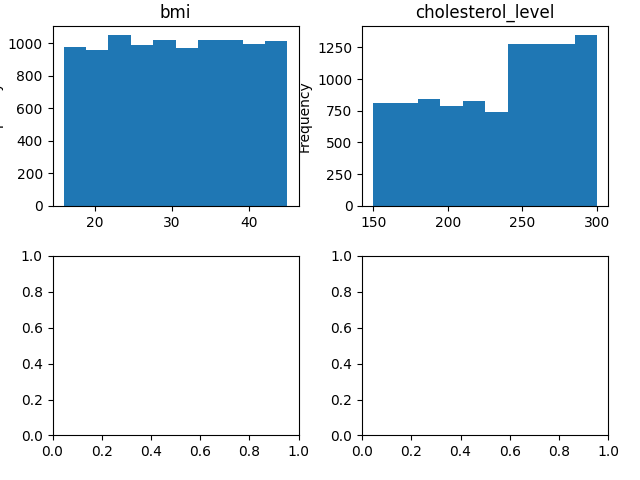

In [31]:
#use histgram plot explore "bmi", "cholesterol_level" numberical columns
features = ["bmi", "cholesterol_level"]
plot_hist(df, features=features, n_rows=2, n_cols=2)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

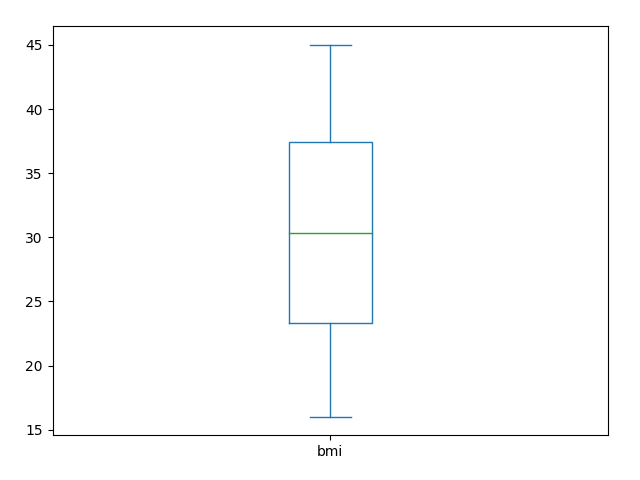

In [32]:
#use boxplot explore "bmi" outlier, the result shows no outlier
plt.clf()
df['bmi'].plot.box()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

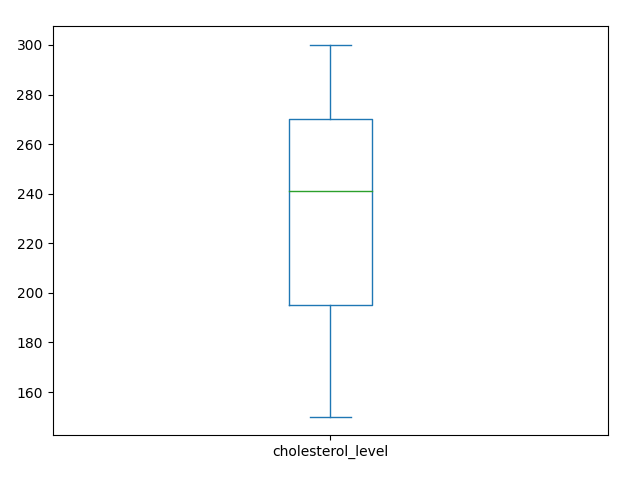

In [33]:
#use boxplot explore "cholesterol_level" outlier, the result shows no outlier
plt.clf()
df["cholesterol_level"].plot.box()
%matplot plt

In [34]:
#change categarical variable as dummies
df = ps.get_dummies(df, columns=["gender","cancer_stage","family_history","smoking_status","treatment_type"], drop_first=False)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   _c0   age diagnosis_date beginning_of_treatment_date   bmi  cholesterol_level  hypertension  asthma  cirrhosis  other_cancer end_treatment_date  survived  gender_Female  gender_Male  cancer_stage_Stage I  cancer_stage_Stage II  cancer_stage_Stage III  cancer_stage_Stage IV  family_history_No  family_history_Yes  smoking_status_Current Smoker  smoking_status_Former Smoker  smoking_status_Never Smoked  smoking_status_Passive Smoker  treatment_type_Chemotherapy  treatment_type_Combined  treatment_type_Radiation  treatment_type_Surgery
0    1  50.0     2023-04-22                  2023-05-02  25.9                208             1       0          0             0         2024-04-25         0              0            1                     0                      0                       1                      0                  0                   1                              0                             0                            0                              1                       

In [35]:
%%pretty
df.to_spark().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,age,diagnosis_date,beginning_of_treatment_date,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,end_treatment_date,survived,gender_Female,gender_Male,cancer_stage_Stage I,cancer_stage_Stage II,cancer_stage_Stage III,cancer_stage_Stage IV,family_history_No,family_history_Yes,smoking_status_Current Smoker,smoking_status_Former Smoker,smoking_status_Never Smoked,smoking_status_Passive Smoker,treatment_type_Chemotherapy,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
1,50.0,2023-04-22,2023-05-02,25.9,208,1,0,0,0,2024-04-25,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,65.0,2023-04-07,2023-04-12,18.9,193,0,0,0,0,2025-03-11,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1
3,51.0,2016-02-07,2016-02-13,34.6,249,1,1,1,0,2017-04-14,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
4,37.0,2023-12-01,2023-12-03,40.2,262,0,0,0,0,2024-09-20,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0
5,50.0,2023-01-04,2023-01-12,32.6,300,1,1,0,0,2024-03-11,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
6,49.0,2018-05-23,2018-05-30,30.1,300,1,1,0,1,2019-07-07,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0
7,51.0,2017-02-20,2017-02-23,44.3,244,1,0,0,0,2018-10-09,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
8,64.0,2021-03-23,2021-04-03,26.9,161,1,0,0,0,2023-02-13,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
9,56.0,2021-12-02,2021-12-04,40.9,286,1,1,0,0,2023-07-07,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10,48.0,2023-12-26,2024-01-08,16.2,223,1,1,1,0,2025-08-20,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


In [36]:
#check again, make sure dataset shape is 10000
df.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(10000, 28)

In [37]:
#ps to pd
import pandas as pd
df = df.to_pandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1722220953791_0003/container_1722220953791_0003_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [38]:
import pandas as pd
df['beginning_of_treatment_date'] = pd.to_datetime(df['beginning_of_treatment_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])
df['duration'] = (df['end_treatment_date'] - df['beginning_of_treatment_date']).dt.days

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
#drop 'diagnosis_date','beginning_of_treatment_date','end_treatment_date' column
df = df.drop(columns=['diagnosis_date','beginning_of_treatment_date','end_treatment_date'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#panda to pyspark.pandas
psdf = ps.from_pandas(df)
spark_df = psdf.to_spark()
spark_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+----+-----------------+------------+------+---------+------------+--------+-------------+-----------+--------------------+---------------------+----------------------+---------------------+-----------------+------------------+-----------------------------+----------------------------+---------------------------+-----------------------------+---------------------------+-----------------------+------------------------+----------------------+--------+
|_c0| age| bmi|cholesterol_level|hypertension|asthma|cirrhosis|other_cancer|survived|gender_Female|gender_Male|cancer_stage_Stage I|cancer_stage_Stage II|cancer_stage_Stage III|cancer_stage_Stage IV|family_history_No|family_history_Yes|smoking_status_Current Smoker|smoking_status_Former Smoker|smoking_status_Never Smoked|smoking_status_Passive Smoker|treatment_type_Chemotherapy|treatment_type_Combined|treatment_type_Radiation|treatment_type_Surgery|duration|
+---+----+----+-----------------+------------+------+---------+-----------

In [41]:
# Convert columns to list of strings
# Exclude '_c0', 'duration', and 'survived'
feature_columns = [col for col in spark_df.columns if col not in ['_c0', 'duration', 'survived']]

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(spark_df)

# Select features and label for classification
classification_data = data.select(col("features"), col("survived").alias("label"))

# Split data into training and test sets for classification
train_data, test_data = classification_data.randomSplit([0.7, 0.3], seed=1234)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=10)

# Train the model
rf_model = rf.fit(train_data)

# Make predictions on the test set
predictions = rf_model.transform(test_data)
predictions.show()

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(23,[0,1,2,3,4,5,...|    0|[81.9100848727748...|[0.81910084872774...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[83.2258291611228...|[0.83225829161122...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[78.8880715409823...|[0.78888071540982...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[79.6616414976214...|[0.79661641497621...|       0.0|
|(23,[0,1,2,3,4,5,...|    1|[78.9646823296859...|[0.78964682329686...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[83.0949298144143...|[0.83094929814414...|       0.0|
|(23,[0,1,2,3,4,5,...|    1|[79.8667851672657...|[0.79866785167265...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[79.3587258722448...|[0.79358725872244...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[80.5376835973128...|[0.80537683597312...|       0.0|
|(23,[0,1,2,3,4,

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

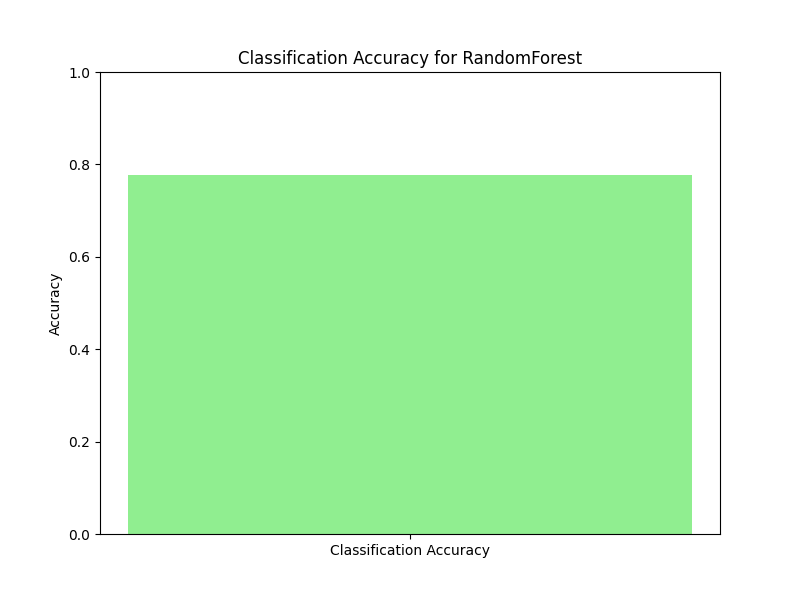

In [43]:
# Plot Classification Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Classification Accuracy'], [accuracy], color='lightgreen')
plt.title('Classification Accuracy for RandomForest')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
%matplot plt

In [44]:
# Initialize KMeans
kmeans = KMeans(featuresCol='features', k=3)  # You can choose the number of clusters (k)

# Train the model
kmeans_model = kmeans.fit(data)

# Make predictions
kmeans_predictions = kmeans_model.transform(data)
kmeans_predictions.show()

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette with squared euclidean distance: {silhouette}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+----+-----------------+------------+------+---------+------------+--------+-------------+-----------+--------------------+---------------------+----------------------+---------------------+-----------------+------------------+-----------------------------+----------------------------+---------------------------+-----------------------------+---------------------------+-----------------------+------------------------+----------------------+--------+--------------------+----------+
|_c0| age| bmi|cholesterol_level|hypertension|asthma|cirrhosis|other_cancer|survived|gender_Female|gender_Male|cancer_stage_Stage I|cancer_stage_Stage II|cancer_stage_Stage III|cancer_stage_Stage IV|family_history_No|family_history_Yes|smoking_status_Current Smoker|smoking_status_Former Smoker|smoking_status_Never Smoked|smoking_status_Passive Smoker|treatment_type_Chemotherapy|treatment_type_Combined|treatment_type_Radiation|treatment_type_Surgery|duration|            features|prediction|
+---+----+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

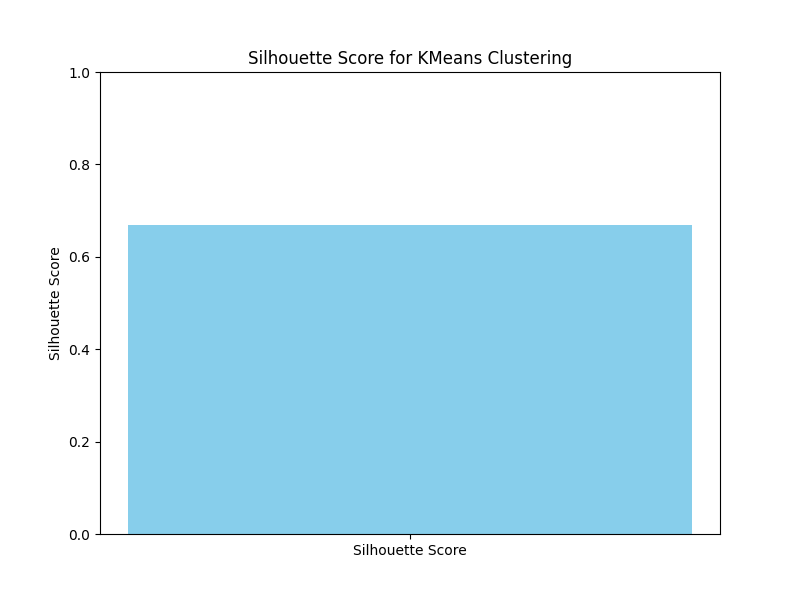

In [45]:
plt.figure(figsize=(8, 6))
plt.bar(['Silhouette Score'], [silhouette], color='skyblue')
plt.title('Silhouette Score for KMeans Clustering')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.show()
%matplot plt